In [8]:
# =========================================
# 05_clustering.ipynb
# Step 1: Imports
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import joblib

sns.set(style="whitegrid")


In [9]:
# =========================================
# Step 2: Load Cleaned Dataset
# =========================================

df = pd.read_csv("../data/processed/cleaned_data.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (5000, 30)


,age,bmi,systolic_bp,diastolic_bp,blood_glucose,cholesterol,heart_rate,hemoglobin,creatinine,diabetes,...,gender_Other,smoking_status_Former,smoking_status_Never,admission_type_Emergency,admission_type_Urgent,age_group_Mid,age_group_Senior,bmi_category_Normal,bmi_category_Over,bmi_category_Obese
0,63.0,21.869197,128.564643,89.326692,60.000000,260.651563,63.317501,15.880686,0.694492,0.0,...,False,True,False,False,False,False,True,True,False,False
1,52.0,24.221554,108.529555,81.290956,120.224209,185.015139,89.222550,13.830224,0.836445,1.0,...,False,False,True,False,False,True,False,True,False,False
2,66.0,25.806556,122.603844,86.938126,90.784321,188.335375,82.026065,12.541138,1.885393,0.0,...,False,False,True,False,False,False,True,False,True,False
3,82.0,27.900396,136.794236,91.250944,93.921765,231.731175,91.173520,15.533963,1.364268,0.0,...,False,False,False,True,False,False,True,False,False,False
4,50.0,23.196762,140.594081,59.567535,83.057078,181.517909,80.458361,15.844581,0.919596,0.0,...,False,False,True,False,False,True,False,False,False,False


In [10]:
# =========================================
# Step 3: Prepare Features for Clustering
# =========================================

X_cluster = df.drop(columns=[
    "risk_category",
    "risk_label",
    "length_of_stay",
    "patient_feedback"
])

# Scale again for clustering safety
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print("Clustering feature shape:", X_scaled.shape)


Clustering feature shape: (5000, 26)


K=2 → Silhouette: 0.1122, Calinski-Harabasz: 640.19
K=3 → Silhouette: 0.1195, Calinski-Harabasz: 477.97
K=4 → Silhouette: 0.0955, Calinski-Harabasz: 411.68
K=5 → Silhouette: 0.1031, Calinski-Harabasz: 399.93
K=6 → Silhouette: 0.0897, Calinski-Harabasz: 364.65
K=7 → Silhouette: 0.0970, Calinski-Harabasz: 349.59


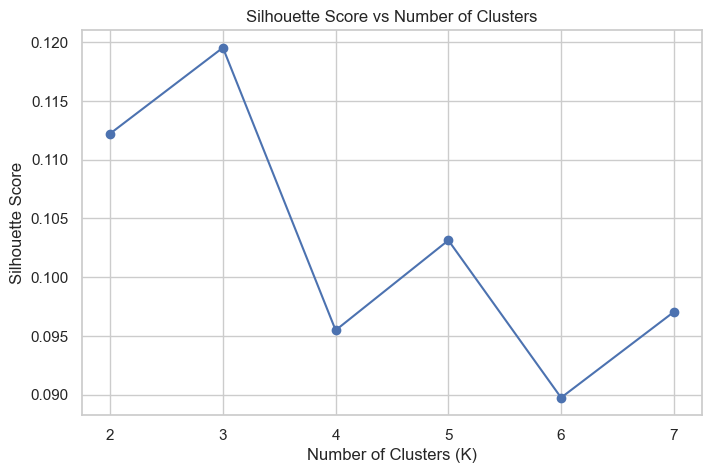

In [11]:
# =========================================
# Step 4: Determine Optimal Number of Clusters
# =========================================

sil_scores = []
ch_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    
    sil_scores.append(sil)
    ch_scores.append(ch)
    
    print(f"K={k} → Silhouette: {sil:.4f}, Calinski-Harabasz: {ch:.2f}")

plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, marker="o")
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()


In [12]:
# =========================================
# Step 5: Final KMeans Clustering (K=3)
# =========================================

kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans_final.fit_predict(X_scaled)

print(df["cluster"].value_counts())


cluster
1    2541
0    2272
2     187
Name: count, dtype: int64


In [ ]:
df["cluster"] = kmeans_final.fit_predict(X_scaled)

In [18]:
# =========================================
# Step 6: Cluster Profiling (Numeric Only)
# =========================================

numeric_df = df.select_dtypes(include=np.number)

cluster_profiles = numeric_df.groupby(df["cluster"]).mean()

cluster_profiles


,age,bmi,systolic_bp,diastolic_bp,blood_glucose,cholesterol,heart_rate,hemoglobin,creatinine,diabetes,hypertension,heart_disease,length_of_stay,pulse_pressure,comorbidity_score,metabolic_risk,risk_label,cluster
cluster,,,,,,,,,,,,,,,,,,
0,55.292254,30.349652,147.229655,84.296822,103.251335,193.651071,78.322489,13.499803,1.146246,0.268046,0.988116,0.125440,10.552773,62.932833,1.381602,0.0,1.063820,0.0
1,53.981897,24.678928,129.120849,78.814573,103.967731,188.815604,78.367833,13.469904,1.123233,0.260527,0.044864,0.000394,8.549588,50.306277,0.305785,0.0,1.183786,1.0
2,54.171123,33.814746,145.875419,85.532389,159.033224,196.955809,77.370415,13.487231,1.113672,0.823529,0.807487,0.074866,11.235639,60.343030,1.705882,1.0,0.401070,2.0


In [20]:
import os
os.makedirs("../models/clustering", exist_ok=True)


In [21]:
joblib.dump(kmeans_final, "../models/clustering/kmeans_model.pkl")
print("Clustering model saved.")


Clustering model saved.
